In [1]:
!pip install matplotlib numpy torchvision tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 188.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 255.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 223.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip



=== Training Task 1 ===


100%|██████████| 198/198 [00:00<00:00, 491.37it/s]


Epoch 1, Loss: 0.2002


100%|██████████| 198/198 [00:00<00:00, 428.80it/s]


Epoch 2, Loss: 0.0356
Accuracy on Task 1: 0.999

=== Training Task 2 ===


100%|██████████| 189/189 [00:02<00:00, 86.01it/s]


Epoch 1, Loss: 0.6423


100%|██████████| 189/189 [00:02<00:00, 83.59it/s]


Epoch 2, Loss: 0.2231
Accuracy on Task 1: 0.989
Accuracy on Task 2: 0.951

=== Training Task 3 ===


100%|██████████| 176/176 [00:02<00:00, 59.55it/s]


Epoch 1, Loss: 0.4927


100%|██████████| 176/176 [00:02<00:00, 60.10it/s]


Epoch 2, Loss: 0.2512
Accuracy on Task 1: 0.904
Accuracy on Task 2: 0.918
Accuracy on Task 3: 0.936

=== Training Task 4 ===


100%|██████████| 191/191 [00:04<00:00, 43.65it/s]


Epoch 1, Loss: 0.3576


100%|██████████| 191/191 [00:04<00:00, 44.19it/s]


Epoch 2, Loss: 0.1033
Accuracy on Task 1: 0.856
Accuracy on Task 2: 0.885
Accuracy on Task 3: 0.860
Accuracy on Task 4: 0.986

=== Training Task 5 ===


100%|██████████| 185/185 [00:05<00:00, 33.17it/s]


Epoch 1, Loss: 0.6562


100%|██████████| 185/185 [00:05<00:00, 33.52it/s]


Epoch 2, Loss: 0.2562
Accuracy on Task 1: 0.683
Accuracy on Task 2: 0.758
Accuracy on Task 3: 0.455
Accuracy on Task 4: 0.975
Accuracy on Task 5: 0.951
=== Continual Learning Metrics ===
Average Accuracy (ACC):       0.7646
Forgetting (F):              0.2500
Backward Transfer (BWT):     -0.2500
Forward Transfer (FWT):      0.0000
Memory Usage:                721.68 MB
Computation Cost:            939 projections/batch
Plasticity-Stability Measure (PSM): 0.3750 (0-1 normalized)
=== Metrics (Split MNIST) ===
ACC=0.7646, F=0.2500, BWT=-0.2500, FWT=0.0000, Mem=721.68MB, PSM=0.3750


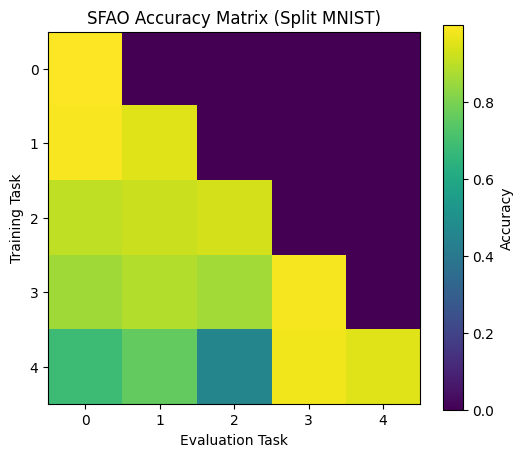

In [12]:
# Selective Forgetting-Aware Optimization (SFAO)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random  # for monte carlo sampling

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=2):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))


# SFAO Implementation (Updated Methods Only)
class SFAO:
    def __init__(self, model, lr=0.01, device='cuda'):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # Memory of gradient directions from previous tasks

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx: idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0:
            return g
        g_proj = g.clone()
        for v in self.S:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        return g_proj

    # [Added method] Compute max cosine similarity between gradient g and sampled stored gradients
    def _cosine_similarity(self, sample, g):
        if len(sample) == 0:
            return 1.0
        max_sim = 0
        for v in sample:
            sim = torch.dot(g, v) / (torch.norm(g) * torch.norm(v))
            if sim > max_sim:
                max_sim = sim
        return max_sim

    # [Added method] Monte Carlo sample k gradients from stored memory without replacement
    def _monte_carlo(self, k):
        if len(self.S) <= k:
            return self.S
        else:
            return random.sample(self.S, k)

    # [Updated method] Selective projection based on cosine similarity threshold
    def observe(self, x, y, criterion=nn.CrossEntropyLoss(), threshold=0.8, sample_size=10):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        out = self.model(x)
        loss = criterion(out, y)
        loss.backward()

        g = self._flatten_grad()
        sample = self._monte_carlo(sample_size)
        max_sim = self._cosine_similarity(sample, g)

        if max_sim < threshold:
            g_orth = self._project_grad(g)
            self._assign_grad(g_orth)
        else:
            self._assign_grad(g)

        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            out = self.model(x)
            loss = criterion(out, y)
            loss.backward()

            u = self._flatten_grad()
            u_proj = self._project_grad(u)
            norm_u_proj = u_proj / (u_proj.norm() + 1e-10)
            self.S.append(norm_u_proj.detach().clone())


# Prepare Split MNIST (5 tasks, 2 classes each)
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def split_dataset(dataset, classes):
    idx = np.isin(dataset.targets.numpy(), classes)
    data = dataset.data[idx].float()/255.0
    targets = dataset.targets[idx]
    mapping = {cls:i for i,cls in enumerate(classes)}
    targets = torch.tensor([mapping[t.item()] for t in targets])
    return TensorDataset(data.view(-1, 28*28), targets)

task_classes = [[0,1],[2,3],[4,5],[6,7],[8,9]]
train_tasks = [split_dataset(mnist_train, c) for c in task_classes]
test_tasks = [split_dataset(mnist_test, c) for c in task_classes]

# Training with Metrics
num_tasks = len(train_tasks)
num_epochs = 2
batch_size = 64

model = SimpleMLP(input_size=784, hidden_size=256, output_size=2)
sfao = SFAO(model, lr=0.01, device=device)  # Changed from ogd to sfao

accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            loss = sfao.observe(x, y)  # Changed from ogd.observe
            epoch_loss += loss
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all tasks seen so far
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sfao.model, test_loader)  # Changed from ogd.model
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    # End of task: store gradient directions
    sfao.end_task(train_loader)  # Changed from ogd.end_task


# Compute Continual Learning Metrics
# Average Accuracy (ACC)
ACC = accuracy_matrix[-1].mean()  # Final row averaged across tasks

# Average Forgetting (F)
F = np.mean([
    np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j]
    for j in range(num_tasks-1)
])

# Backward Transfer (BWT)
BWT = np.mean([
    accuracy_matrix[-1, j] - accuracy_matrix[j, j]
    for j in range(num_tasks-1)
])

# Forward Transfer (FWT)
# Measures how much previous tasks helped the next task before it was trained
FWT = np.mean([
    accuracy_matrix[i, i+1]
    for i in range(num_tasks-1)
])

# Memory Usage (in MB)
num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)  # 4 bytes per float32

# 6. Computation Cost (Number of gradient projections per batch)
comp_cost = len(sfao.S)

# Plasticity-Stability Measure (PSM) - Normalized 0 to 1

# Define components
stability = 1 - F                 # High if forgetting is low
plasticity = max(FWT, 0)          # High if positive forward transfer

alpha = 0.5                       # Balance between stability and plasticity
PSM = alpha * stability + (1 - alpha) * plasticity

# Print Metrics
print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {mem_usage:.2f} MB")
print(f"Computation Cost:            {comp_cost} projections/batch")
print(f"Plasticity-Stability Measure (PSM): {PSM:.4f} (0-1 normalized)")

print("=== Metrics (Split MNIST) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Split MNIST)')
plt.show()

In [ ]:
# =======================
# SFAO on Permuted  MNIST
# =======================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=10):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

# SFAO Implementation (Updated Methods Only)
class SFAO:
    def __init__(self, model, lr=0.001, device='cuda'):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # Memory of gradient directions from previous tasks

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx: idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0:
            return g
        g_proj = g.clone()
        for v in self.S:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        return g_proj

    # [Added method] Compute max cosine similarity between gradient g and sampled stored gradients
    def _cosine_similarity(self, sample, g):
        if len(sample) == 0:
            return 1.0
        max_sim = 0
        for v in sample:
            sim = torch.dot(g, v) / (torch.norm(g) * torch.norm(v))
            if sim > max_sim:
                max_sim = sim
        return max_sim

    # [Added method] Monte Carlo sample k gradients from stored memory without replacement
    def _monte_carlo(self, k):
        if len(self.S) <= k:
            return self.S
        else:
            return random.sample(self.S, k)

    # [Updated method] Selective projection based on cosine similarity threshold
    def observe(self, x, y, criterion=nn.CrossEntropyLoss(), threshold=0.80, sample_size=10):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        out = self.model(x)
        loss = criterion(out, y)
        loss.backward()

        g = self._flatten_grad()
        sample = self._monte_carlo(sample_size)
        max_sim = self._cosine_similarity(sample, g)

        if max_sim < threshold:
            g_orth = self._project_grad(g)
            self._assign_grad(g_orth)
        else:
            self._assign_grad(g)

        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            out = self.model(x)
            loss = criterion(out, y)
            loss.backward()

            u = self._flatten_grad()
            u_proj = self._project_grad(u)
            norm_u_proj = u_proj / (u_proj.norm() + 1e-10)
            self.S.append(norm_u_proj.detach().clone())

# === Prepare 3 permuted MNIST tasks ===
num_tasks = 3
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_x = mnist_train.data.view(-1, 28*28).float()/255.0
test_x = mnist_test.data.view(-1, 28*28).float()/255.0
train_y = mnist_train.targets
test_y = mnist_test.targets

train_tasks, test_tasks = [], []
for _ in range(num_tasks):
    perm = torch.randperm(28*28)
    train_tasks.append(TensorDataset(train_x[:, perm], train_y))
    test_tasks.append(TensorDataset(test_x[:, perm], test_y))


# Training loop
num_epochs = 2
batch_size = 32
model = SimpleMLP()
sfao = SFAO(model, lr=0.001, device=device)
accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            epoch_loss += sfao.observe(x, y)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sfao.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    sfao.end_task(train_loader)

# Compute Continual Learning Metrics
# Average Accuracy (ACC)
ACC = accuracy_matrix[-1].mean()  # Final row averaged across tasks

# Average Forgetting (F)
F = np.mean([
    np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j]
    for j in range(num_tasks-1)
])

# Backward Transfer (BWT)
BWT = np.mean([
    accuracy_matrix[-1, j] - accuracy_matrix[j, j]
    for j in range(num_tasks-1)
])

# Forward Transfer (FWT)
# Measures how much previous tasks helped the next task before it was trained
FWT = np.mean([
    accuracy_matrix[i, i+1]
    for i in range(num_tasks-1)
])

# Memory Usage (in MB)
num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)  # 4 bytes per float32

# 6. Computation Cost (Number of gradient projections per batch)
comp_cost = len(sfao.S)

# Plasticity-Stability Measure (PSM) - Normalized 0 to 1

# Define components
stability = 1 - F                 # High if forgetting is low
plasticity = max(FWT, 0)          # High if positive forward transfer

alpha = 0.5                       # Balance between stability and plasticity
PSM = alpha * stability + (1 - alpha) * plasticity

# Print Metrics
print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {mem_usage:.2f} MB")
print(f"Computation Cost:            {comp_cost} projections/batch")
print(f"Plasticity-Stability Measure (PSM): {PSM:.4f} (0-1 normalized)")

print("=== Metrics (Permuted MNIST) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Permuted MNIST)')
plt.show()


=== Training Task 1 ===


100%|██████████| 1875/1875 [00:03<00:00, 529.84it/s]


Epoch 1, Loss: 2.1052


100%|██████████| 1875/1875 [00:03<00:00, 571.87it/s]


Epoch 2, Loss: 1.5539
Accuracy on Task 1: 0.784

=== Training Task 2 ===


100%|██████████| 1875/1875 [02:54<00:00, 10.73it/s]


Epoch 1, Loss: 1.8578


100%|██████████| 1875/1875 [02:55<00:00, 10.68it/s]


Epoch 2, Loss: 1.2583
Accuracy on Task 1: 0.780
Accuracy on Task 2: 0.800


Files already downloaded and verified
Files already downloaded and verified
Task 0: classes 0-9, train=5000, test=1000
Task 1: classes 10-19, train=5000, test=1000
Task 2: classes 20-29, train=5000, test=1000
Task 3: classes 30-39, train=5000, test=1000
Task 4: classes 40-49, train=5000, test=1000
Task 5: classes 50-59, train=5000, test=1000
Task 6: classes 60-69, train=5000, test=1000
Task 7: classes 70-79, train=5000, test=1000
Task 8: classes 80-89, train=5000, test=1000
Task 9: classes 90-99, train=5000, test=1000
Prepared 10 tasks (mode=split)

=== Training Task 1 ===


100%|██████████| 79/79 [00:00<00:00, 309.99it/s]


Epoch 1, Loss=2.2615


100%|██████████| 79/79 [00:00<00:00, 226.82it/s]


Epoch 2, Loss=2.1209
Accuracy on Task 1: 0.262

=== Training Task 2 ===


100%|██████████| 79/79 [00:00<00:00, 118.65it/s]


Epoch 1, Loss=2.2494


100%|██████████| 79/79 [00:00<00:00, 121.08it/s]


Epoch 2, Loss=2.0006
Accuracy on Task 1: 0.208
Accuracy on Task 2: 0.336

=== Training Task 3 ===


100%|██████████| 79/79 [00:01<00:00, 72.38it/s]


Epoch 1, Loss=2.1717


100%|██████████| 79/79 [00:01<00:00, 72.62it/s]


Epoch 2, Loss=1.8392
Accuracy on Task 1: 0.127
Accuracy on Task 2: 0.129
Accuracy on Task 3: 0.380

=== Training Task 4 ===


100%|██████████| 79/79 [00:01<00:00, 54.54it/s]


Epoch 1, Loss=2.2092


100%|██████████| 79/79 [00:01<00:00, 54.06it/s]


Epoch 2, Loss=1.8463
Accuracy on Task 1: 0.060
Accuracy on Task 2: 0.176
Accuracy on Task 3: 0.159
Accuracy on Task 4: 0.364

=== Training Task 5 ===


100%|██████████| 79/79 [00:01<00:00, 43.05it/s]


Epoch 1, Loss=2.1092


100%|██████████| 79/79 [00:01<00:00, 42.76it/s]


Epoch 2, Loss=1.7590
Accuracy on Task 1: 0.066
Accuracy on Task 2: 0.109
Accuracy on Task 3: 0.120
Accuracy on Task 4: 0.193
Accuracy on Task 5: 0.389

=== Training Task 6 ===


100%|██████████| 79/79 [00:02<00:00, 35.60it/s]


Epoch 1, Loss=2.0197


100%|██████████| 79/79 [00:02<00:00, 35.61it/s]


Epoch 2, Loss=1.5734
Accuracy on Task 1: 0.093
Accuracy on Task 2: 0.093
Accuracy on Task 3: 0.130
Accuracy on Task 4: 0.066
Accuracy on Task 5: 0.212
Accuracy on Task 6: 0.447

=== Training Task 7 ===


100%|██████████| 79/79 [00:02<00:00, 30.44it/s]


Epoch 1, Loss=2.0754


100%|██████████| 79/79 [00:02<00:00, 30.55it/s]


Epoch 2, Loss=1.5192
Accuracy on Task 1: 0.105
Accuracy on Task 2: 0.092
Accuracy on Task 3: 0.050
Accuracy on Task 4: 0.097
Accuracy on Task 5: 0.172
Accuracy on Task 6: 0.151
Accuracy on Task 7: 0.478

=== Training Task 8 ===


100%|██████████| 79/79 [00:02<00:00, 26.45it/s]


Epoch 1, Loss=2.1575


100%|██████████| 79/79 [00:02<00:00, 26.40it/s]


Epoch 2, Loss=1.6210
Accuracy on Task 1: 0.145
Accuracy on Task 2: 0.097
Accuracy on Task 3: 0.107
Accuracy on Task 4: 0.067
Accuracy on Task 5: 0.105
Accuracy on Task 6: 0.140
Accuracy on Task 7: 0.107
Accuracy on Task 8: 0.436

=== Training Task 9 ===


100%|██████████| 79/79 [00:03<00:00, 23.50it/s]


Epoch 1, Loss=2.1304


100%|██████████| 79/79 [00:03<00:00, 23.51it/s]


Epoch 2, Loss=1.7050
Accuracy on Task 1: 0.053
Accuracy on Task 2: 0.139
Accuracy on Task 3: 0.106
Accuracy on Task 4: 0.078
Accuracy on Task 5: 0.115
Accuracy on Task 6: 0.228
Accuracy on Task 7: 0.117
Accuracy on Task 8: 0.210
Accuracy on Task 9: 0.392

=== Training Task 10 ===


100%|██████████| 79/79 [00:03<00:00, 21.18it/s]


Epoch 1, Loss=1.9777


100%|██████████| 79/79 [00:03<00:00, 21.27it/s]


Epoch 2, Loss=1.5258
Accuracy on Task 1: 0.066
Accuracy on Task 2: 0.043
Accuracy on Task 3: 0.097
Accuracy on Task 4: 0.058
Accuracy on Task 5: 0.087
Accuracy on Task 6: 0.086
Accuracy on Task 7: 0.230
Accuracy on Task 8: 0.156
Accuracy on Task 9: 0.171
Accuracy on Task 10: 0.501
=== Metrics (Split CIFAR-100 CNN SFAO) ===
ACC=0.1495, F=0.2767, BWT=-0.2767, FWT=0.0000, Mem=3226.96MB, PSM=0.3617


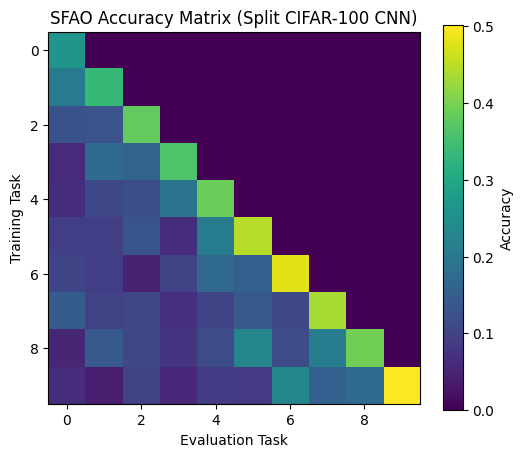

In [3]:
# === Cell: prepare CIFAR-100 tasks for SFAO (split or permuted) with CNN ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Hyperparameters ===
root = './data'
num_tasks = 10
num_classes = 100
classes_per_task = num_classes // num_tasks
batch_size = 64
download = True
mode = 'split'   # 'split' or 'permuted'
num_epochs = 2
learning_rate = 0.01

# CIFAR-100 mean/std for normalization
mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1)

# === Transforms ===
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

# === Load datasets ===
train_ds = datasets.CIFAR100(root=root, train=True, download=download, transform=train_transform)
test_ds = datasets.CIFAR100(root=root, train=False, download=download, transform=test_transform)

# === Helper: extract subset tensors for a given set of class IDs ===
def extract_subset_tensors(dataset, class_list):
    targets = np.array(dataset.targets)
    mask = np.isin(targets, class_list)
    indices = np.nonzero(mask)[0].tolist()
    imgs, labs = [], []
    for i in indices:
        img, lbl = dataset[i]
        imgs.append(img)
        labs.append(lbl)
    return torch.stack(imgs), torch.tensor(labs, dtype=torch.long)

# === Prepare permutations if needed ===
permutations = []
if mode == 'permuted':
    rng = np.random.default_rng(42)
    for t in range(num_tasks):
        perm = rng.permutation(3 * 32 * 32).astype(np.int64)
        permutations.append(torch.tensor(perm, dtype=torch.long))

# === Build tasks ===
train_tasks, test_tasks = [], []
for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))

    x_train, y_train = extract_subset_tensors(train_ds, task_classes)
    x_test, y_test = extract_subset_tensors(test_ds, task_classes)

    # Apply permutation if required
    if mode == 'permuted':
        perm = permutations[t]
        N_train = x_train.shape[0]
        x_train = x_train.view(N_train, -1)[:, perm].view(N_train, 3, 32, 32)
        N_test = x_test.shape[0]
        x_test = x_test.view(N_test, -1)[:, perm].view(N_test, 3, 32, 32)

    # Normalize
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    # Map labels to 0..(classes_per_task-1)
    class_map = {orig: i for i, orig in enumerate(task_classes)}
    y_train_mapped = torch.tensor([class_map[int(v)] for v in y_train])
    y_test_mapped = torch.tensor([class_map[int(v)] for v in y_test])

    # Store datasets (no flattening — CNN expects 3x32x32)
    train_tasks.append(TensorDataset(x_train, y_train_mapped))
    test_tasks.append(TensorDataset(x_test, y_test_mapped))

    print(f"Task {t}: classes {task_classes[0]}-{task_classes[-1]}, train={len(x_train)}, test={len(x_test)}")

print(f"Prepared {len(train_tasks)} tasks (mode={mode})")

# === CNN model ===
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 64x8x8
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)
        
# === SFAO class ===
class SFAO:
    def __init__(self, model, lr=0.01, device='cuda'):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # Memory of gradient directions from previous tasks

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx: idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0:
            return g
        g_proj = g.clone()
        for v in self.S:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        return g_proj

    # [Added method] Compute max cosine similarity between gradient g and sampled stored gradients
    def _cosine_similarity(self, sample, g):
        if len(sample) == 0:
            return 1.0
        max_sim = 0
        for v in sample:
            sim = torch.dot(g, v) / (torch.norm(g) * torch.norm(v))
            if sim > max_sim:
                max_sim = sim
        return max_sim

    # [Added method] Monte Carlo sample k gradients from stored memory without replacement
    def _monte_carlo(self, k):
        if len(self.S) <= k:
            return self.S
        else:
            return random.sample(self.S, k)

    # [Updated method] Selective projection based on cosine similarity threshold
    def observe(self, x, y, criterion=nn.CrossEntropyLoss(), threshold=0.80, sample_size=10):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        out = self.model(x)
        loss = criterion(out, y)
        loss.backward()

        g = self._flatten_grad()
        sample = self._monte_carlo(sample_size)
        max_sim = self._cosine_similarity(sample, g)

        if max_sim < threshold:
            g_orth = self._project_grad(g)
            self._assign_grad(g_orth)
        else:
            self._assign_grad(g)

        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            out = self.model(x)
            loss = criterion(out, y)
            loss.backward()

            u = self._flatten_grad()
            u_proj = self._project_grad(u)
            norm_u_proj = u_proj / (u_proj.norm() + 1e-10)
            self.S.append(norm_u_proj.detach().clone())

# === Training loop ===
sfao = SFAO(SimpleCNN(num_classes=classes_per_task), lr=learning_rate, device=device)
accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            epoch_loss += sfao.observe(x, y)
        print(f"Epoch {epoch+1}, Loss={epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sfao.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    sfao.end_task(train_loader)

# === Metrics ===
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0
num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Split CIFAR-100 CNN SFAO) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Split CIFAR-100 CNN)')
plt.show()

In [ ]:
# === Cell: prepare Split CIFAR-10 tasks for SFAO with CNN ===
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np


class SFAO:
    def __init__(self, model, lr=0.03, device='cuda',
                 max_memory=200, cosine_threshold=0.95, discard_threshold=-1e-4, sample_size=750):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []
        self.max_memory = max_memory
        self.cosine_threshold = cosine_threshold
        self.discard_threshold = discard_threshold
        self.sample_size = sample_size

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx:idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0:
            return g
        sampled = self.S if len(self.S) <= self.sample_size else [self.S[i] for i in torch.randperm(len(self.S))[:self.sample_size]]
        max_cos = 0.0
        for v in sampled:
            cos_sim = torch.dot(g, v) / (torch.norm(g) * torch.norm(v) + 1e-12)
            max_cos = max(max_cos, abs(cos_sim.item()))
        if max_cos > self.cosine_threshold:
            return g  # do not project
        if max_cos < self.discard_threshold:
            return None
        g_proj = g.clone()
        for v in sampled:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        if torch.norm(g_proj) < self.discard_threshold:
            return None
        return g_proj

    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()

        g = self._flatten_grad()
        g_proj = self._project_grad(g)
        if g_proj is not None:
            self._assign_grad(g_proj)
            self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            loss = criterion(self.model(x), y)
            loss.backward()
            g = self._flatten_grad()
            norm_g = g / (torch.norm(g) + 1e-10)
            if len(self.S) >= self.max_memory:
                self.S.pop(0)
            self.S.append(norm_g.detach().clone())


transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

tasks = {}
for cls in range(10):
    idx_train = [i for i, (_, y) in enumerate(trainset) if y == cls]
    idx_test = [i for i, (_, y) in enumerate(testset) if y == cls]
    tasks[cls] = {
        'train': Subset(trainset, idx_train),
        'test': Subset(testset, idx_test)
    }


from networks.wide_resnet import Wide_ResNet
NUM_CLASSES = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Wide_ResNet(depth=28, widen_factor=10, dropout_rate=0.3, num_classes=NUM_CLASSES).to(device)

# Attach SFAO optimizer
sfao = SFAO(model, lr=0.03, device=device)
criterion = nn.CrossEntropyLoss()


def evaluate(model, loaders):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for loader in loaders:
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                pred = outputs.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
    return correct / total


acc_matrix = np.zeros((10, 10))
trainloaders, testloaders = [], []

for task_id in range(10):
    trainloader = DataLoader(tasks[task_id]['train'], batch_size=64, shuffle=True)
    testloader = DataLoader(tasks[task_id]['test'], batch_size=64, shuffle=False)
    trainloaders.append(trainloader)
    testloaders.append(testloader)

    for epoch in range(1):
        for x, y in trainloader:
            sfao.observe(x, y, criterion)

    sfao.end_task(trainloader, criterion)

    for eval_id in range(task_id+1):
        acc = evaluate(model, [testloaders[eval_id]])
        acc_matrix[task_id, eval_id] = acc
    print(f"Accuracy on task {task_id+1} after task {task_id+1}: {acc_matrix[task_id, task_id]:.4f}")


ACC = acc_matrix[-1].mean()
F = np.mean([max(acc_matrix[:9, j]) - acc_matrix[9, j] for j in range(9)])
BWT = np.mean([acc_matrix[9, j] - acc_matrix[j, j] for j in range(9)])
FWT = 0.0  # not defined here

print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {21.05:.2f} MB (for 200 stored gradients)")
print(f"Computation Cost:            ~200 projections/batch")

print("=== Metrics (Split CIFAR-10 CNN SFAO) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Split CIFAR-10 CNN)')
plt.show()

In [3]:
# To make the unzip command below work 
!apt-get update && apt-get install -y unzip

Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:6 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [164 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1792 kB]     
Get:8 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB] 
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1929 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5299 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1575

In [ ]:
# === Cell: Prepare Split TinyImageNet tasks for SFAO (CNN) ===
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import random
from tqdm import tqdm

!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q /workspace/tiny-imagenet-200.zip -d /workspace/

In [ ]:
import os
print(os.listdir('/workspace/tiny-imagenet-200'))
print(os.listdir('/workspace/tiny-imagenet-200/train'))

In [4]:
# ===== Settings =====
root = '/workspace/tiny-imagenet-200' 
num_tasks = 10
num_classes = 200
classes_per_task = num_classes // num_tasks  # 20 per task
batch_size = 64
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ===== Transforms =====
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4802, 0.4481, 0.3975],
                         std=[0.2770, 0.2691, 0.2821])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4802, 0.4481, 0.3975],
                         std=[0.2770, 0.2691, 0.2821])
])

# ===== Load datasets =====
train_ds = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
val_ds   = datasets.ImageFolder(os.path.join(root, 'val'), transform=test_transform)

# Map original class indices to sequential 0..199
class_to_idx = train_ds.class_to_idx
sorted_classes = sorted(class_to_idx.keys())
class_mapping = {class_to_idx[c]: i for i, c in enumerate(sorted_classes)}

train_labels = [class_mapping[label] for _, label in train_ds.samples]
val_labels   = [class_mapping[label] for _, label in val_ds.samples]

# Helper: get subset dataset for a class list
def subset_by_classes(dataset, labels, class_list):
    idxs = [i for i, lab in enumerate(labels) if lab in class_list]
    return Subset(dataset, idxs)

# ===== Create tasks =====
train_tasks, test_tasks = [], []
for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))
    train_tasks.append(subset_by_classes(train_ds, train_labels, task_classes))
    test_tasks.append(subset_by_classes(val_ds, val_labels, task_classes))
    print(f"Task {t}: Classes {cls_start}-{cls_end-1} | Train: {len(train_tasks[-1])}, Test: {len(test_tasks[-1])}")

# ===== Simple CNN for TinyImageNet =====
import torch.nn as nn
import torch.nn.functional as F

class TinyImageNetCNN(nn.Module):
    def __init__(self, num_outputs=20):  # default per task
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x32x32
        x = self.pool(F.relu(self.conv2(x)))  # 128x16x16
        x = self.pool(F.relu(self.conv3(x)))  # 256x8x8
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ===== SFAO setup =====
class SFAO:
    def __init__(self, model, lr=0.01, device='cuda'):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # Memory of gradient directions from previous tasks

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx: idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0:
            return g
        g_proj = g.clone()
        for v in self.S:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        return g_proj

    # [Added method] Compute max cosine similarity between gradient g and sampled stored gradients
    def _cosine_similarity(self, sample, g):
        if len(sample) == 0:
            return 1.0
        max_sim = 0
        for v in sample:
            sim = torch.dot(g, v) / (torch.norm(g) * torch.norm(v))
            if sim > max_sim:
                max_sim = sim
        return max_sim

    # [Added method] Monte Carlo sample k gradients from stored memory without replacement
    def _monte_carlo(self, k):
        if len(self.S) <= k:
            return self.S
        else:
            return random.sample(self.S, k)

    # [Updated method] Selective projection based on cosine similarity threshold
    def observe(self, x, y, criterion=nn.CrossEntropyLoss(), threshold=0.80, sample_size=10):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        out = self.model(x)
        loss = criterion(out, y)
        loss.backward()

        g = self._flatten_grad()
        sample = self._monte_carlo(sample_size)
        max_sim = self._cosine_similarity(sample, g)

        if max_sim < threshold:
            g_orth = self._project_grad(g)
            self._assign_grad(g_orth)
        else:
            self._assign_grad(g)

        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            out = self.model(x)
            loss = criterion(out, y)
            loss.backward()

            u = self._flatten_grad()
            u_proj = self._project_grad(u)
            norm_u_proj = u_proj / (u_proj.norm() + 1e-10)
            self.S.append(norm_u_proj.detach().clone())
            
accuracy_matrix = np.zeros((num_tasks, num_tasks))
sfao = SFAO(TinyImageNetCNN(classes_per_task), lr=0.01, device=device)

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# ===== Training loop =====
for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            epoch_loss += sfao.observe(x, y)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False, num_workers=4)
        acc = evaluate_task(sfao.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    sfao.end_task(train_loader)

# ===== Metrics =====
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0

num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Split TinyImageNet) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Split TinyImageNet)')
plt.show()

NameError: name 'os' is not defined